In [1]:
# from google.colab import drive
# drive.mount("/content/drives")

In [2]:
# import list
import os
import cv2
import torch
import torchvision
import random
import numpy
import time
import itertools
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.utils.data as data
from torch.utils.data import DataLoader
from PIL import Image
from glob import glob
from matplotlib import pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
def show_image_mask(img, mask, cmap='gray'): # visualisation test
    fig = plt.figure(figsize=(5,5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap=cmap)
    plt.axis('off')

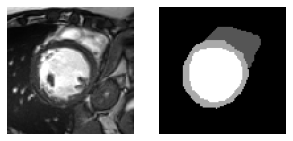

True

In [4]:
data_dir = './data/train'
image = cv2.imread(os.path.join(data_dir,'image','cmr1.png'), cv2.IMREAD_UNCHANGED)
mask = cv2.imread(os.path.join(data_dir,'mask','cmr1_mask.png'), cv2.IMREAD_UNCHANGED)
show_image_mask(image, mask, cmap='gray')
plt.pause(1)
cv2.imwrite(os.path.join('./','cmr1.png'), mask*85)

In [5]:
# Check the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"The current device is {device}")

The current device is cuda:0


In [6]:
# read data & data augmentation

classes = ['0','1','2','3']
class TrainDataset(data.Dataset):
    def __init__(self, root=''):
        super(TrainDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))
        self.mask_files = []
        # Define random flip
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root,'mask',basename[:-4]+'_mask.png'))
            self.datatransform1 = torchvision.transforms.Compose([
                torchvision.transforms.RandomHorizontalFlip(p = 1)
            ])
            self.datatransform2 = torchvision.transforms.Compose([
                torchvision.transforms.RandomHorizontalFlip(p = 0)
            ])
        
            

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            label = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            # Data augmentation - random flip
            image1 = Image.fromarray(data)
            image2 = Image.fromarray(label)
            # Define a random value op
            op = random.randint(100007, 100000007)
            op = op % 2
            if op: # Flip when op is odd
                image1 = self.datatransform1(image1)
                image2 = self.datatransform1(image2)
            else:  # Flip when op is even
                image1 = self.datatransform2(image1)
                image2 = self.datatransform2(image2)
            data = numpy.array(image1)
            label = numpy.array(image2)
            
            return torch.from_numpy(data).float(), torch.from_numpy(label).float()

    def __len__(self):
        return len(self.img_files)

class TestDataset(data.Dataset):
    def __init__(self, root=''):
        super(TestDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))

    def __getitem__(self, index):
            img_path = self.img_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float()

    def __len__(self):
        return len(self.img_files)
    

In [7]:
# UNet 3+
class unetConv2(nn.Module):
  """(convolution => [BN] => ReLU) * 2"""
  #define a class contains two steps of convolution
  def __init__(self, in_channels, out_channels, is_batchnorm):
    super().__init__()
    self.double_conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

  def forward(self, x):
    return self.double_conv(x)

#define the unet_3plus network

class UNet_3Plus(nn.Module):

  def __init__(self):
    super(UNet_3Plus, self).__init__()
    in_channels = 1
    n_classes = 4
    feature_scale = 4
    is_deconv = True
    is_batchnorm = True
    self.is_deconv = is_deconv
    self.in_channels = in_channels
    self.is_batchnorm = is_batchnorm
    self.feature_scale = feature_scale
    
    #define a list contains all the channels used in the encoder and decoder
    
    filters = [64, 128, 256, 512, 1024]

    ## -------------Encoder--------------
    # defines five steps of encoding and each step reduce half of both the width and length of pictures
    # and double the original channels
    
    self.conv1 = unetConv2(self.in_channels, filters[0], self.is_batchnorm)
    self.maxpool1 = nn.MaxPool2d(kernel_size=2)

    self.conv2 = unetConv2(filters[0], filters[1], self.is_batchnorm)
    self.maxpool2 = nn.MaxPool2d(kernel_size=2)

    self.conv3 = unetConv2(filters[1], filters[2], self.is_batchnorm)
    self.maxpool3 = nn.MaxPool2d(kernel_size=2)

    self.conv4 = unetConv2(filters[2], filters[3], self.is_batchnorm)
    self.maxpool4 = nn.MaxPool2d(kernel_size=2)

    self.conv5 = unetConv2(filters[3], filters[4], self.is_batchnorm)

    ## -------------Decoder--------------
    
    #CatBlocks is 5 because when we do upsample, it will merge features of 5 states and each feature 
    #has 64 channels
    
    self.CatChannels = filters[0]
    self.CatBlocks = 5
    self.UpChannels = self.CatChannels * self.CatBlocks

    '''stage 4d'''
    # h1->96*96 hd4->12*12 pooling 8 times to do the downsampling
    
    self.h1_PT_hd4 = nn.MaxPool2d(8, 8, ceil_mode=True)
    self.h1_PT_hd4_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
    self.h1_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
    self.h1_PT_hd4_relu = nn.ReLU(inplace=True)

    # h2->48*48 hd4->12*12 pooling 4 times to do the downsampling
    self.h2_PT_hd4 = nn.MaxPool2d(4, 4, ceil_mode=True)
    self.h2_PT_hd4_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
    self.h2_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
    self.h2_PT_hd4_relu = nn.ReLU(inplace=True)

    #h3->24*24 hd4->12*12 pooling 2 times to do the downsampling
    self.h3_PT_hd4 = nn.MaxPool2d(2, 2, ceil_mode=True)
    self.h3_PT_hd4_conv = nn.Conv2d(filters[2], self.CatChannels, 3, padding=1)
    self.h3_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
    self.h3_PT_hd4_relu = nn.ReLU(inplace=True)

    # h4->12*12, hd4->12*12, Concatenation
    self.h4_Cat_hd4_conv = nn.Conv2d(filters[3], self.CatChannels, 3, padding=1)
    self.h4_Cat_hd4_bn = nn.BatchNorm2d(self.CatChannels)
    self.h4_Cat_hd4_relu = nn.ReLU(inplace=True)

    # h5->6*6, hd4->12*12, Upsample 2 times
    self.hd5_UT_hd4 = nn.Upsample(scale_factor=2, mode='bilinear')  
    self.hd5_UT_hd4_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
    self.hd5_UT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
    self.hd5_UT_hd4_relu = nn.ReLU(inplace=True)

    # fusion(h1_PT_hd4, h2_PT_hd4, h3_PT_hd4, h4_Cat_hd4, hd5_UT_hd4)
    # when finish the concatenation, do a convolution of hd4
    # and it will merge all the features of 5 ceils and its channels will be 5*64 = 320
    self.conv4d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1) 
    self.bn4d_1 = nn.BatchNorm2d(self.UpChannels)
    self.relu4d_1 = nn.ReLU(inplace=True)

    '''stage 3d'''
    # h1->96*96, hd3->24*24, pooling 4 times to do the downsampling
    self.h1_PT_hd3 = nn.MaxPool2d(4, 4, ceil_mode=True)
    self.h1_PT_hd3_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
    self.h1_PT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
    self.h1_PT_hd3_relu = nn.ReLU(inplace=True)

    # h2->48*48, hd3->24*24, pooling 4 times to do the downsampling
    self.h2_PT_hd3 = nn.MaxPool2d(2, 2, ceil_mode=True)
    self.h2_PT_hd3_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
    self.h2_PT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
    self.h2_PT_hd3_relu = nn.ReLU(inplace=True)

    # h3->24*24, hd3->24*24, Concatenation
    self.h3_Cat_hd3_conv = nn.Conv2d(filters[2], self.CatChannels, 3, padding=1)
    self.h3_Cat_hd3_bn = nn.BatchNorm2d(self.CatChannels)
    self.h3_Cat_hd3_relu = nn.ReLU(inplace=True)

    # hd4->12*12, hd3->24*24, Upsample 2 times
    self.hd4_UT_hd3 = nn.Upsample(scale_factor=2, mode='bilinear')
    self.hd4_UT_hd3_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
    self.hd4_UT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
    self.hd4_UT_hd3_relu = nn.ReLU(inplace=True)

    # hd5->6*6, hd3->24*24, Upsample 4 times
    self.hd5_UT_hd3 = nn.Upsample(scale_factor=4, mode='bilinear')  
    self.hd5_UT_hd3_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
    self.hd5_UT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
    self.hd5_UT_hd3_relu = nn.ReLU(inplace=True)

    # fusion(h1_PT_hd3, h2_PT_hd3, h3_Cat_hd3, hd4_UT_hd3, hd5_UT_hd3)
    # when finish the concatenation, do a convolution of hd3
    # and it will merge all the features of 5 ceils and its channels will be 5*64 = 320
    self.conv3d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  
    self.bn3d_1 = nn.BatchNorm2d(self.UpChannels)
    self.relu3d_1 = nn.ReLU(inplace=True)

    '''stage 2d '''
    # h1->96*96, hd2->48*48, Pooling 2 times
    self.h1_PT_hd2 = nn.MaxPool2d(2, 2, ceil_mode=True)
    self.h1_PT_hd2_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
    self.h1_PT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
    self.h1_PT_hd2_relu = nn.ReLU(inplace=True)

    # h2->48*48, hd2->48*48, Concatenation
    self.h2_Cat_hd2_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
    self.h2_Cat_hd2_bn = nn.BatchNorm2d(self.CatChannels)
    self.h2_Cat_hd2_relu = nn.ReLU(inplace=True)

    # hd3->24*24, hd2->48*48, Upsample 2 times
    self.hd3_UT_hd2 = nn.Upsample(scale_factor=2, mode='bilinear')  
    self.hd3_UT_hd2_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
    self.hd3_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
    self.hd3_UT_hd2_relu = nn.ReLU(inplace=True)

    # hd4->12*12, hd2->48*48, Upsample 4 times
    self.hd4_UT_hd2 = nn.Upsample(scale_factor=4, mode='bilinear')  
    self.hd4_UT_hd2_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
    self.hd4_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
    self.hd4_UT_hd2_relu = nn.ReLU(inplace=True)

    # hd5->6*6, hd2->48*48, Upsample 8 times
    self.hd5_UT_hd2 = nn.Upsample(scale_factor=8, mode='bilinear') 
    self.hd5_UT_hd2_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
    self.hd5_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
    self.hd5_UT_hd2_relu = nn.ReLU(inplace=True)

    # fusion(h1_PT_hd2, h2_Cat_hd2, hd3_UT_hd2, hd4_UT_hd2, hd5_UT_hd2)
    # when finish the concatenation, do a convolution of hd2
    # and it will merge all the features of 5 ceils and its channels will be 5*64 = 320
    self.conv2d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1) 
    self.bn2d_1 = nn.BatchNorm2d(self.UpChannels)
    self.relu2d_1 = nn.ReLU(inplace=True)

    '''stage 1d'''
    # h1->96*96, hd1->96*96, Concatenation
    self.h1_Cat_hd1_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
    self.h1_Cat_hd1_bn = nn.BatchNorm2d(self.CatChannels)
    self.h1_Cat_hd1_relu = nn.ReLU(inplace=True)

    # hd2->48*48, hd1->96*96, Upsample 2 times
    self.hd2_UT_hd1 = nn.Upsample(scale_factor=2, mode='bilinear')
    self.hd2_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
    self.hd2_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
    self.hd2_UT_hd1_relu = nn.ReLU(inplace=True)

    # hd3->24*24, hd1->96*96, Upsample 4 times
    self.hd3_UT_hd1 = nn.Upsample(scale_factor=4, mode='bilinear')
    self.hd3_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
    self.hd3_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
    self.hd3_UT_hd1_relu = nn.ReLU(inplace=True)

    # hd4->12*12, hd1->96*96, Upsample 8 times
    self.hd4_UT_hd1 = nn.Upsample(scale_factor=8, mode='bilinear')
    self.hd4_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
    self.hd4_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
    self.hd4_UT_hd1_relu = nn.ReLU(inplace=True)

    # hd5->6*6, hd1->96*96, Upsample 16 times
    self.hd5_UT_hd1 = nn.Upsample(scale_factor=16, mode='bilinear')
    self.hd5_UT_hd1_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
    self.hd5_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
    self.hd5_UT_hd1_relu = nn.ReLU(inplace=True)

    # fusion(h1_Cat_hd1, hd2_UT_hd1, hd3_UT_hd1, hd4_UT_hd1, hd5_UT_hd1)
    # when finish the concatenation, do a convolution of hd1
    # and it will merge all the features of 5 ceils and its channels will be 5*64 = 320
    self.conv1d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1) 
    self.bn1d_1 = nn.BatchNorm2d(self.UpChannels)
    self.relu1d_1 = nn.ReLU(inplace=True)

    # output
    # a covolution function convert the channels from 320 to 4
    self.outconv1 = nn.Conv2d(self.UpChannels, n_classes, 3, padding=1)

  def forward(self, inputs):
    ## -------------Encoder-------------
    h1 = self.conv1(inputs)  # h1->96*96*64

    h2 = self.maxpool1(h1)
    h2 = self.conv2(h2)  # h2->48*48*128

    h3 = self.maxpool2(h2)
    h3 = self.conv3(h3)  # h3->24*24*256

    h4 = self.maxpool3(h3)
    h4 = self.conv4(h4)  # h4->12*12*512

    h5 = self.maxpool4(h4)
    hd5 = self.conv5(h5)  # h5->6*6*1024

    ## -------------Decoder-------------
    #use the steps above to concat the features of h1,h2,h3,h4,hd5 and makes a new cell hd4
    #combines 5 matrix of 12*12*64 to a matrix 12*12*320
    h1_PT_hd4 = self.h1_PT_hd4_relu(self.h1_PT_hd4_bn(self.h1_PT_hd4_conv(self.h1_PT_hd4(h1))))
    h2_PT_hd4 = self.h2_PT_hd4_relu(self.h2_PT_hd4_bn(self.h2_PT_hd4_conv(self.h2_PT_hd4(h2))))
    h3_PT_hd4 = self.h3_PT_hd4_relu(self.h3_PT_hd4_bn(self.h3_PT_hd4_conv(self.h3_PT_hd4(h3))))
    h4_Cat_hd4 = self.h4_Cat_hd4_relu(self.h4_Cat_hd4_bn(self.h4_Cat_hd4_conv(h4)))
    hd5_UT_hd4 = self.hd5_UT_hd4_relu(self.hd5_UT_hd4_bn(self.hd5_UT_hd4_conv(self.hd5_UT_hd4(hd5))))
    hd4 = self.relu4d_1(self.bn4d_1(self.conv4d_1(
        torch.cat((h1_PT_hd4, h2_PT_hd4, h3_PT_hd4, h4_Cat_hd4, hd5_UT_hd4), 1)))) # hd4->40*40*UpChannels
    
    #use the steps above to concat the features of h1,h2,h3,hd4,hd5 and makes a new cell hd3
    #combines 5 matrix of 24*24*64 to a matrix 24*24*320
    h1_PT_hd3 = self.h1_PT_hd3_relu(self.h1_PT_hd3_bn(self.h1_PT_hd3_conv(self.h1_PT_hd3(h1))))
    h2_PT_hd3 = self.h2_PT_hd3_relu(self.h2_PT_hd3_bn(self.h2_PT_hd3_conv(self.h2_PT_hd3(h2))))
    h3_Cat_hd3 = self.h3_Cat_hd3_relu(self.h3_Cat_hd3_bn(self.h3_Cat_hd3_conv(h3)))
    hd4_UT_hd3 = self.hd4_UT_hd3_relu(self.hd4_UT_hd3_bn(self.hd4_UT_hd3_conv(self.hd4_UT_hd3(hd4))))
    hd5_UT_hd3 = self.hd5_UT_hd3_relu(self.hd5_UT_hd3_bn(self.hd5_UT_hd3_conv(self.hd5_UT_hd3(hd5))))
    hd3 = self.relu3d_1(self.bn3d_1(self.conv3d_1(
        torch.cat((h1_PT_hd3, h2_PT_hd3, h3_Cat_hd3, hd4_UT_hd3, hd5_UT_hd3), 1)))) # hd3->80*80*UpChannels
    
    #use the steps above to concat the features of h1,h2,hd3,hd4,hd5 and makes a new cell hd2
    #combines 5 matrix of 48*48*64 to a matrix 48*48*320
    h1_PT_hd2 = self.h1_PT_hd2_relu(self.h1_PT_hd2_bn(self.h1_PT_hd2_conv(self.h1_PT_hd2(h1))))
    h2_Cat_hd2 = self.h2_Cat_hd2_relu(self.h2_Cat_hd2_bn(self.h2_Cat_hd2_conv(h2)))
    hd3_UT_hd2 = self.hd3_UT_hd2_relu(self.hd3_UT_hd2_bn(self.hd3_UT_hd2_conv(self.hd3_UT_hd2(hd3))))
    hd4_UT_hd2 = self.hd4_UT_hd2_relu(self.hd4_UT_hd2_bn(self.hd4_UT_hd2_conv(self.hd4_UT_hd2(hd4))))
    hd5_UT_hd2 = self.hd5_UT_hd2_relu(self.hd5_UT_hd2_bn(self.hd5_UT_hd2_conv(self.hd5_UT_hd2(hd5))))
    hd2 = self.relu2d_1(self.bn2d_1(self.conv2d_1(
        torch.cat((h1_PT_hd2, h2_Cat_hd2, hd3_UT_hd2, hd4_UT_hd2, hd5_UT_hd2), 1)))) # hd2->160*160*UpChannels
    
    #use the steps above to concat the features of h1,hd2,hd3,hd4,hd5 and makes a new cell hd1
    #combines 5 matrix of 96*96*64 to a matrix 96*96*320
    h1_Cat_hd1 = self.h1_Cat_hd1_relu(self.h1_Cat_hd1_bn(self.h1_Cat_hd1_conv(h1)))
    hd2_UT_hd1 = self.hd2_UT_hd1_relu(self.hd2_UT_hd1_bn(self.hd2_UT_hd1_conv(self.hd2_UT_hd1(hd2))))
    hd3_UT_hd1 = self.hd3_UT_hd1_relu(self.hd3_UT_hd1_bn(self.hd3_UT_hd1_conv(self.hd3_UT_hd1(hd3))))
    hd4_UT_hd1 = self.hd4_UT_hd1_relu(self.hd4_UT_hd1_bn(self.hd4_UT_hd1_conv(self.hd4_UT_hd1(hd4))))
    hd5_UT_hd1 = self.hd5_UT_hd1_relu(self.hd5_UT_hd1_bn(self.hd5_UT_hd1_conv(self.hd5_UT_hd1(hd5))))
    hd1 = self.relu1d_1(self.bn1d_1(self.conv1d_1(
        torch.cat((h1_Cat_hd1, hd2_UT_hd1, hd3_UT_hd1, hd4_UT_hd1, hd5_UT_hd1), 1)))) # hd1->320*320*UpChannels
    
    #output the final results
    #96*96*320 -> 96*96*4
    d1 = self.outconv1(hd1)

    return d1


In [8]:
# UNet
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    #define a function contains two steps of convolution
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if mid_channels is None:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down,self).__init__()
        # define a function contains two times of pooling and two steps of convolution
        self.max_pool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.max_pool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, Transpose=False):
        super(Up,self).__init__()
        # Transpose is to do deconvolution but it is not used in this network
        # use the bilinear to double the size of matrix and use the conv2d to minimize the channels to the half
        if Transpose:
            self.up = nn.ConvTranspose2d(in_channels, in_channels//2, 2, stride=2)
        else:
            self.up = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                                    nn.Conv2d(in_channels, in_channels // 2, kernel_size=1, padding=0),
                                    nn.ReLU(inplace=True))
        self.conv = DoubleConv(in_channels, out_channels)
        # self.up.apply(self.init_weights)

    def forward(self, x1, x2):

        x1 = self.up(x1)
        # it may not use padding but we write here in case.
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = nn.functional.pad(x1, (diffX // 2, diffX - diffX//2,
                                    diffY // 2, diffY - diffY//2))
        # concat the features of two graph
        x = torch.cat([x2,x1], dim=1)
        x = self.conv(x)
        return x


# define a function of convolution to output the result
class out_conv(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(out_conv,self).__init__()
        self.conv = nn.Conv2d(in_channels,out_channels,kernel_size=1)

    def forward(self,x):
        return self.conv(x)

# define the unet 
class Unet(nn.Module):
    def __init__(self):
        super(Unet,self).__init__()
        self.in_channels = 1
        self.inc = DoubleConv(self.in_channels,64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.drop3 = nn.Dropout2d(0.05)
        self.down4 = Down(512, 1024)
        self.drop4 = nn.Dropout2d(0.05)
        self.up1 = Up(1024, 512, False)
        self.up2 = Up(512,256,False)
        self.up3 = Up(256, 128, False)
        self.up4 = Up(128, 64, False)
        self.out = out_conv(64,4)
        # self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
    def forward(self,x):
        self.x = x
        # 96*96*1 -> 96*96*64
        x1 = self.inc(self.x)
        # 96*96*64->48*48*128
        x2 = self.down1(x1)
        # 48*48*128->24*24*256
        x3 = self.down2(x2)
        # 24*24*256->12*12*512
        x4 = self.down3(x3)
        x4 = self.drop3(x4)
        # in the original unet network, it has depth of 5.But in this work, 
        # we will use the l3 version of this network and reduce x5 because the size of picture is not big
        # we find reducing the x5 will make the result better
        
        # x5 = self.down4(x4)
        # x5 = self.drop4(x5)
        # x = self.up1(x5, x4)

        # 12*12*512->24*24*512 
        # x4 becomes 24*24*256 and merge the channels with x3

        x = self.up2(x4, x3)
        # 24*24*512->48*48*512 
        # x becomes 48*48*256 and merge the channels with x2
        x = self.up3(x, x2)
        # 48*48*512->96*96*512
        # x becomes 48*48*512 and merge the channel with x1
        x = self.up4(x, x1)
        # 96*96*512->96*96*4
        x = self.out(x)
        return x


In [9]:
# Dice Score
def categorical_dice(mask1, mask2, label_class=1):
    """
    Dice score of a specified class between two volumes of label masks.
    (classes are encoded but by label class number not one-hot )
    Note: stacks of 2D slices are considered volumes.

    Args:
        mask1: N label masks, numpy array shaped (H, W, N)
        mask2: N label masks, numpy array shaped (H, W, N)
        label_class: the class over which to calculate dice scores

    Returns:
        volume_dice
    """
    mask1_pos = (mask1 == label_class).astype(np.float32)
    mask2_pos = (mask2 == label_class).astype(np.float32)
    dice = 2 * np.sum(mask1_pos * mask2_pos) / (np.sum(mask1_pos) + np.sum(mask2_pos))
    return dice

In [10]:
# define Loss function
class losses():
    def __init__(self):
        self.CE= nn.CrossEntropyLoss()
    
    # CrossEntropyLoss
    def forward(self, pred, true):
        return self.CE(pred,true)
        
    # Self-define Loss function: CrossEntropyLoss + Dice Score
    def forward2(self,pred,true,pred_mask,true_mask):
        self.val = 0
        for i in range(3):
            self.val = self.val + categorical_dice(pred_mask.data.cpu().numpy(), true_mask.data.cpu().numpy(), i+1)
        return self.CE(pred,true) + (3 - self.val)/2


In [11]:
# Function: optimize the learning rate
def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=15):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.5**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

LR is set to 0.001
Epoch 0, average loss: 0.532486
0  saved model
validation average loss: 0.392146
Epoch 1, average loss: 0.351086
1  saved model
validation average loss: 0.264617
Epoch 2, average loss: 0.252251
2  saved model
validation average loss: 0.253416
Epoch 3, average loss: 0.214166
3  saved model
validation average loss: 0.200337
Epoch 4, average loss: 0.179891
validation average loss: 0.205002
Epoch 5, average loss: 0.170794
validation average loss: 0.202580
Epoch 6, average loss: 0.147398
6  saved model
validation average loss: 0.181094
Epoch 7, average loss: 0.149953
7  saved model
validation average loss: 0.162766
Epoch 8, average loss: 0.126646
8  saved model
validation average loss: 0.158477
Epoch 9, average loss: 0.131059
9  saved model
validation average loss: 0.152866
Epoch 10, average loss: 0.117331
10  saved model
validation average loss: 0.140281
Epoch 11, average loss: 0.110697
11  saved model
validation average loss: 0.134707
Epoch 12, average loss: 0.096940
12

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


Epoch 30, average loss: 0.050268
30  saved model
validation average loss: 0.073766
Epoch 31, average loss: 0.044030
31  saved model
validation average loss: 0.066305
Epoch 32, average loss: 0.045164
32  saved model
validation average loss: 0.064698
Epoch 33, average loss: 0.043863
validation average loss: 0.067822
Epoch 34, average loss: 0.046332
34  saved model
validation average loss: 0.064107
Epoch 35, average loss: 0.042711
validation average loss: 0.068332
Epoch 36, average loss: 0.044518
validation average loss: 0.071220
Epoch 37, average loss: 0.042052
validation average loss: 0.069259
Epoch 38, average loss: 0.042166
validation average loss: 0.065501
Epoch 39, average loss: 0.041967
validation average loss: 0.070829
Epoch 40, average loss: 0.041323
validation average loss: 0.072059
Epoch 41, average loss: 0.042065
validation average loss: 0.070224
Epoch 42, average loss: 0.041179
validation average loss: 0.066775
Epoch 43, average loss: 0.041381
validation average loss: 0.06667

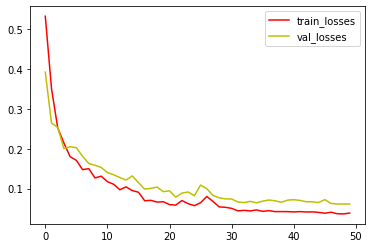

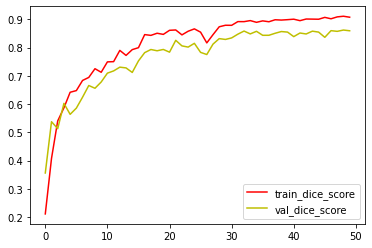

In [12]:
# Train Unet

T1=time.time()

model = Unet().to(device)
learning_rate = 0.001
weight_decay=1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Initialize the training dataset
data_path = './data/train'
num_workers = 1
batch_size = 4
train_set = TrainDataset(data_path)
training_data_loader = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)
# Initialize the validting dataset
val_data_path = './data/val'
val_num_workers = 1
val_batch_size = 4
val_set = TrainDataset(val_data_path)
val_data_loader = DataLoader(dataset=val_set, num_workers=val_num_workers, batch_size=val_batch_size, shuffle=False)

# Initialize the valuses
running_loss = 0.0
my_loss = losses()
Max_val = 100000000000
train_losses = []
val_losses = []
plot_train_dice = []
plot_val_dice = []

# Initialize the timer
T1=time.time()

# Epoch
num_epoches = 50

# Fetch images and labels.
for epoch in range(num_epoches):

    # Optimizer
    optimizer = exp_lr_scheduler(optimizer, epoch)
    
    # Initialize the values
    total_loss = 0
    val_total_loss = 0
    train_dice = 0
    train_dice_cnt = 0
    val_dice = 0
    val_dice_cnt = 0
    
    # For-loop on the training set
    for iteration, sample in enumerate(training_data_loader):
        
        # Initialize the images and labels
        img, mask = sample
        img = img.to(device)
        mask = mask.to(device)

        # Adjust the dimension
        img = img.unsqueeze(1)

        # Gradient -> 0
        optimizer.zero_grad()

        # Output
        outputs = model(img)
        output = outputs.argmax(dim=1)

        for i in range(batch_size):
            output_dice = output[i]
            output_dice.unsqueeze(1)
            #dice_score = categorical_dice(output_dice.data.cpu().numpy(), mask[i].data.cpu().numpy(),1)
            #dice_score += categorical_dice(output_dice.data.cpu().numpy(), mask[i].data.cpu().numpy(),2)
            #dice_score += categorical_dice(output_dice.data.cpu().numpy(), mask[i].data.cpu().numpy(),3)
            #dice_score /= 3
            # train_dice += dice_score
            # train_dice_cnt = train_dice_cnt + 1
                        
            dices = []
            for k in range(1, 4):
                dices.append(categorical_dice(output_dice.data.cpu().numpy(), mask[i].data.cpu().numpy(), label_class=k))
            # compute mean dice score without nan produced when both masks don't contain label_class i
            dice_score = np.nanmean(np.array(dices))
            train_dice += dice_score
            train_dice_cnt = train_dice_cnt + 1

        # Loss and the total
        loss = my_loss.forward2(outputs,mask.long(),mask, output)
        total_loss += loss
        loss.backward()

        # Update w
        optimizer.step()

    # After 1 for-loop on the training dataset
    # Average Loss  
    train_losses.append(total_loss.item()/100)
    plot_train_dice.append(train_dice / 100)
    print("Epoch %d, average loss: %f" % (epoch, total_loss/100))
    
    # For-loop on the validating set
    for iteration, sample in enumerate(val_data_loader):
        # Initialize the images and labels
        img, mask = sample
        img = img.to(device)
        mask = mask.to(device)

        # Adjust the dimension
        img = img.unsqueeze(1)

        # Context-manager
        with torch.no_grad():
            outputs = model(img)
            output = outputs.argmax(dim=1)

        for i in range(batch_size):
            output_dice = output[i]
            output_dice.unsqueeze(1)
            # dice_score = categorical_dice(output_dice.data.cpu().numpy(), mask[i].data.cpu().numpy(),1)
            # dice_score += categorical_dice(output_dice.data.cpu().numpy(), mask[i].data.cpu().numpy(),2)
            # dice_score += categorical_dice(output_dice.data.cpu().numpy(), mask[i].data.cpu().numpy(),3)
            #dice_score /= 3
            #val_dice += dice_score
            #val_dice_cnt = val_dice_cnt + 1  
            
            dices = []
            for k in range(1, 4):
                dices.append(categorical_dice(output_dice.data.cpu().numpy(), mask[i].data.cpu().numpy(), label_class=k))
            # compute mean dice score without nan produced when both masks don't contain label_class i
            dice_score = np.nanmean(np.array(dices))
            val_dice += dice_score
            val_dice_cnt = val_dice_cnt + 1

        # Loss and the total
        loss = my_loss.forward2(outputs, mask.long(),mask,output)
        val_total_loss += loss
    
    # After 1 for-loop on the validating dataset
    # Average Loss
    val_losses.append(val_total_loss.item()/20)
    plot_val_dice.append(val_dice / 20)

    # Upper boundary for the validating Loss
    if Max_val > val_total_loss:
        Max_val = val_total_loss
        print(epoch, " saved model")
        PATH = './Unet_01.pth'
        torch.save(model.state_dict(), PATH)
    
    # Output the Loss
    print("validation average loss: %f" % (val_total_loss/20))


# After this epoch
# Output the timer
T2=time.time()
print('Using time: %fs' % (T2-T1))

# Output the Loss
print(len(train_losses))
print(len(val_losses))

# Plot the Loss
plt.plot(range(num_epoches), train_losses,c='r',label = "train_losses")
plt.plot(range(num_epoches), val_losses,c='y',label = "val_losses")
plt.legend(loc='best')
plt.savefig('Unet_1.jpg')
plt.show()
plt.plot(range(num_epoches), plot_train_dice,c='r',label = "train_dice_score")
plt.plot(range(num_epoches), plot_val_dice,c='y',label = "val_dice_score")
plt.legend(loc='best')
plt.savefig('Unet_2.jpg')
plt.show()

LR is set to 0.001
Epoch 0, average loss: 0.304997
0  saved model
validation average loss: 0.194735
Epoch 1, average loss: 0.157576
1  saved model
validation average loss: 0.160306
Epoch 2, average loss: 0.129232
2  saved model
validation average loss: 0.131444
Epoch 3, average loss: 0.095625
3  saved model
validation average loss: 0.106128
Epoch 4, average loss: 0.089149
validation average loss: 0.122817
Epoch 5, average loss: 0.085484
validation average loss: 0.124084


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


Epoch 6, average loss: 0.098076
validation average loss: 0.110013
Epoch 7, average loss: 0.081265
7  saved model
validation average loss: 0.092446
Epoch 8, average loss: 0.072024
validation average loss: 0.092718
Epoch 9, average loss: 0.055853
9  saved model
validation average loss: 0.079213
Epoch 10, average loss: 0.059285
10  saved model
validation average loss: 0.073138
Epoch 11, average loss: 0.053388
11  saved model
validation average loss: 0.068426
Epoch 12, average loss: 0.045659
12  saved model
validation average loss: 0.063508
Epoch 13, average loss: 0.046944
validation average loss: 0.065345
Epoch 14, average loss: 0.044516
validation average loss: 0.069987
LR is set to 0.0005
Epoch 15, average loss: 0.043754
15  saved model
validation average loss: 0.059738
Epoch 16, average loss: 0.039235
16  saved model
validation average loss: 0.059308
Epoch 17, average loss: 0.039576
17  saved model
validation average loss: 0.057365
Epoch 18, average loss: 0.039535
validation average lo

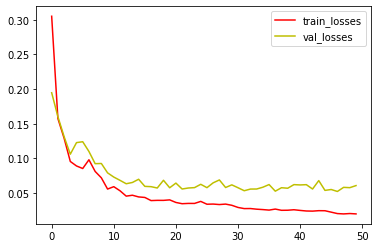

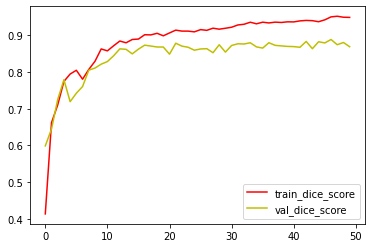

In [15]:
# Train Unet3plus

T1=time.time()

model = UNet_3Plus().to(device)
learning_rate = 0.001
weight_decay=1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Initialize the training dataset
data_path = './data/train'
num_workers = 1
batch_size = 4
train_set = TrainDataset(data_path)
training_data_loader = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)
# Initialize the validting dataset
val_data_path = './data/val'
val_num_workers = 1
val_batch_size = 4
val_set = TrainDataset(val_data_path)
val_data_loader = DataLoader(dataset=val_set, num_workers=val_num_workers, batch_size=val_batch_size, shuffle=False)

# Initialize the valuses
running_loss = 0.0
my_loss = losses()
Max_val = 100000000000
train_losses = []
val_losses = []
plot_train_dice = []
plot_val_dice = []

# Initialize the timer
T1=time.time()

# Epoch
num_epoches = 50

# Fetch images and labels.
for epoch in range(num_epoches):

    # Optimizer
    optimizer = exp_lr_scheduler(optimizer, epoch)
    
    # Initialize the values
    total_loss = 0
    val_total_loss = 0
    train_dice = 0
    train_dice_cnt = 0
    val_dice = 0
    val_dice_cnt = 0
    
    # For-loop on the training set
    for iteration, sample in enumerate(training_data_loader):
        
        # Initialize the images and labels
        img, mask = sample
        img = img.to(device)
        mask = mask.to(device)

        # Adjust the dimension
        img = img.unsqueeze(1)

        # Gradient -> 0
        optimizer.zero_grad()

        # Output
        outputs = model(img)
        output = outputs.argmax(dim=1)

        for i in range(batch_size):
            output_dice = output[i]
            output_dice.unsqueeze(1)
            #dice_score = categorical_dice(output_dice.data.cpu().numpy(), mask[i].data.cpu().numpy(),1)
            #dice_score += categorical_dice(output_dice.data.cpu().numpy(), mask[i].data.cpu().numpy(),2)
            #dice_score += categorical_dice(output_dice.data.cpu().numpy(), mask[i].data.cpu().numpy(),3)
            #dice_score /= 3
            #train_dice += dice_score
            #train_dice_cnt = train_dice_cnt + 1
            dices = []
            for k in range(1, 4):
                dices.append(categorical_dice(output_dice.data.cpu().numpy(), mask[i].data.cpu().numpy(), label_class=k))
            dice_score = np.nanmean(np.array(dices))
            train_dice += dice_score
            train_dice_cnt = train_dice_cnt + 1        

        # Loss and the total
        loss = my_loss.forward2(outputs,mask.long(),mask, output)
        total_loss += loss
        loss.backward()

        # Update w
        optimizer.step()

    # After 1 for-loop on the training dataset
    # Average Loss  
    train_losses.append(total_loss.item()/100)
    plot_train_dice.append(train_dice / 100)
    print("Epoch %d, average loss: %f" % (epoch, total_loss/100))
    
    # For-loop on the validating set
    for iteration, sample in enumerate(val_data_loader):
        # Initialize the images and labels
        img, mask = sample
        img = img.to(device)
        mask = mask.to(device)

        # Adjust the dimension
        img = img.unsqueeze(1)

        # Context-manager
        with torch.no_grad():
            outputs = model(img)
            output = outputs.argmax(dim=1)

        for i in range(batch_size):
            output_dice = output[i]
            output_dice.unsqueeze(1)
              #dice_score = categorical_dice(output_dice.data.cpu().numpy(), mask[i].data.cpu().numpy(),1)
              #dice_score += categorical_dice(output_dice.data.cpu().numpy(), mask[i].data.cpu().numpy(),2)
              #dice_score += categorical_dice(output_dice.data.cpu().numpy(), mask[i].data.cpu().numpy(),3)
              #dice_score /= 3
              #val_dice += dice_score
              #val_dice_cnt = val_dice_cnt + 1
            dices = []
                # ignore the dice score for background (label 0)
            for k in range(1, 4):
                dices.append(categorical_dice(output_dice.data.cpu().numpy(), mask[i].data.cpu().numpy(), label_class=k))
                # compute mean dice score without nan produced when both masks don't contain label_class i
            dice_score = np.nanmean(np.array(dices))
            val_dice += dice_score
            val_dice_cnt = val_dice_cnt + 1     

        # Loss and the total
        loss = my_loss.forward2(outputs, mask.long(),mask,output)
        val_total_loss += loss
    
    # After 1 for-loop on the validating dataset
    # Average Loss
    val_losses.append(val_total_loss.item()/20)
    plot_val_dice.append(val_dice / 20)

    # Upper boundary for the validating Loss
    if Max_val > val_total_loss:
        Max_val = val_total_loss
        print(epoch, " saved model")
        PATH = './Unet3+_01.pth'
        torch.save(model.state_dict(), PATH)
    
    # Output the Loss
    print("validation average loss: %f" % (val_total_loss/20))


# After this epoch
# Output the timer
T2=time.time()
print('Using time: %fs' % (T2-T1))

# Output the Loss
print(len(train_losses))
print(len(val_losses))

# Plot the Loss
plt.plot(range(num_epoches), train_losses,c='r',label = "train_losses")
plt.plot(range(num_epoches), val_losses,c='y',label = "val_losses")
plt.legend(loc='best')
plt.savefig('Unet_3_1.jpg')
plt.show()
plt.plot(range(num_epoches), plot_train_dice,c='r',label = "train_dice_score")
plt.plot(range(num_epoches), plot_val_dice,c='y',label = "val_dice_score")
plt.legend(loc='best')
plt.savefig('Unet_3_2.jpg')
plt.show()

In [16]:
# UNet_3Plus()
model_UNet3plus = UNet_3Plus().to(device)
PATH = './Unet3+_01.pth'
model_UNet3plus_Max = torch.load(PATH, map_location='cpu')
model_UNet3plus.load_state_dict(model_UNet3plus_Max)
model_UNet3plus.to(device)


# UNet()
model_UNet = Unet().to(device)
PATH2 = './Unet_01.pth'
model_UNet_Max = torch.load(PATH2, map_location='cpu')
model_UNet.load_state_dict(model_UNet_Max)
model_UNet.to(device)


Unet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (max_pool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momen

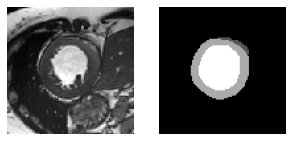

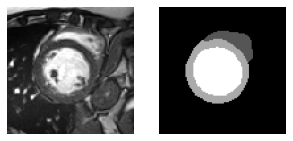

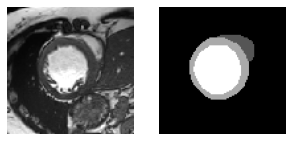

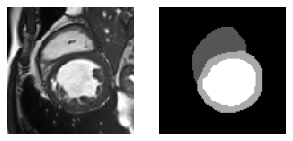

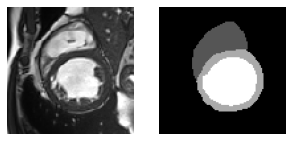

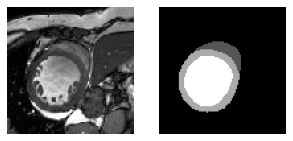

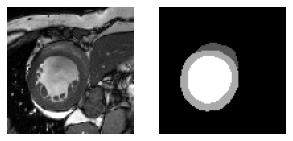

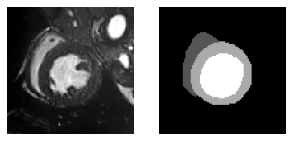

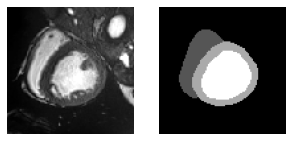

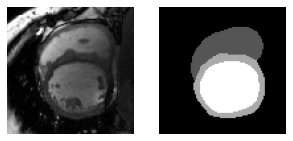

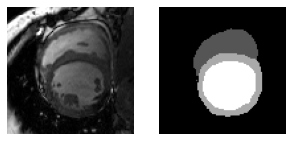

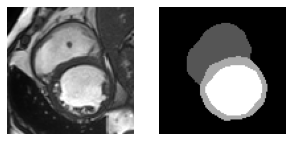

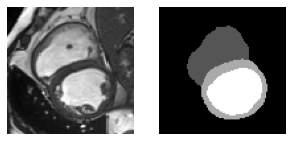

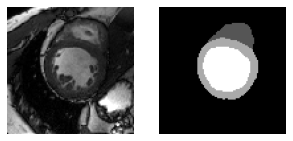

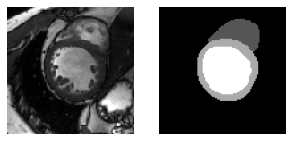

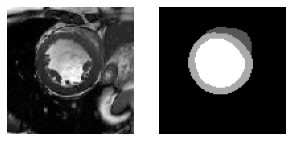

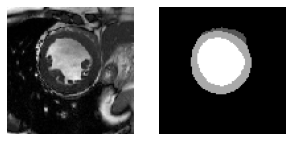

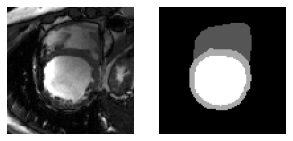

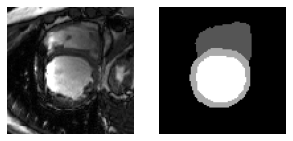

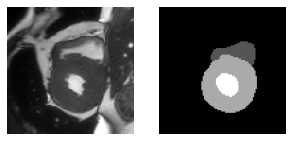

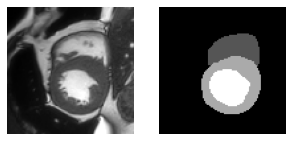

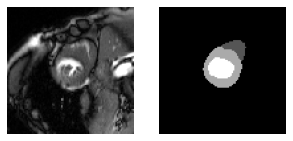

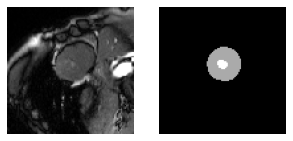

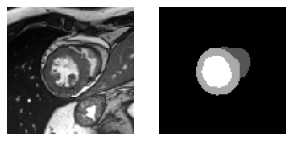

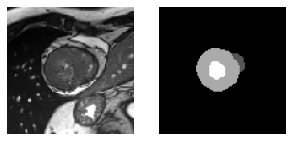

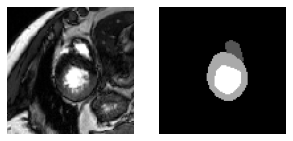

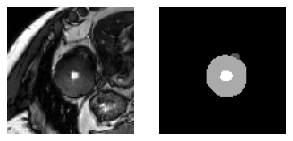

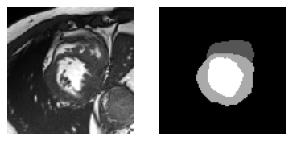

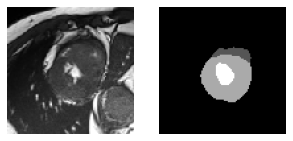

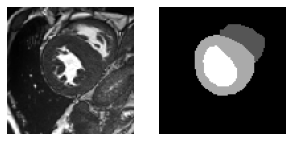

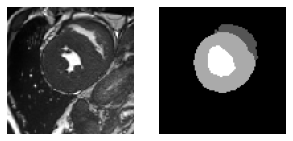

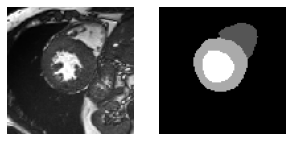

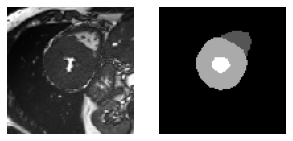

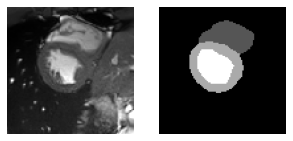

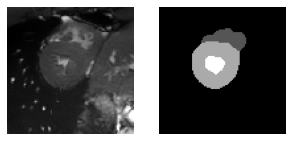

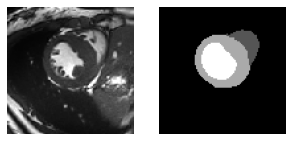

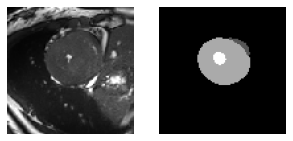

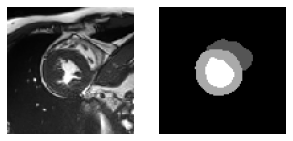

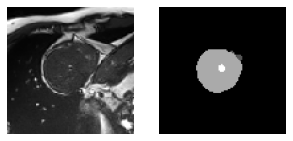

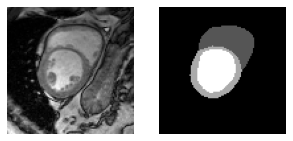

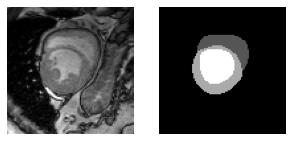

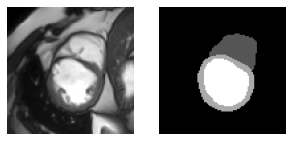

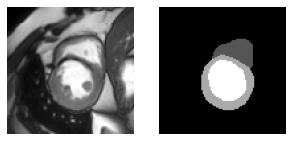

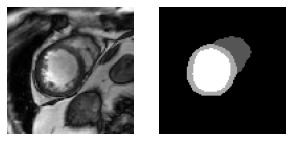

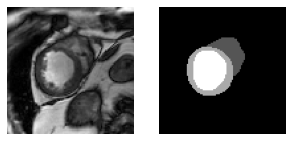

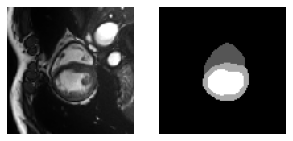

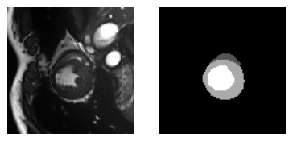

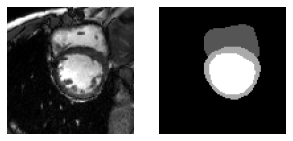

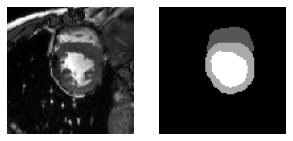

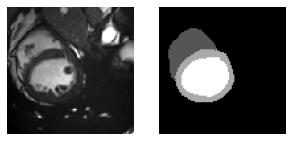

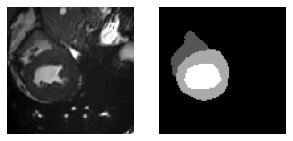

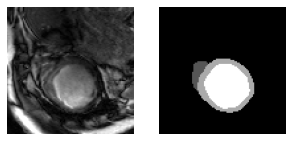

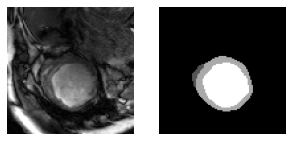

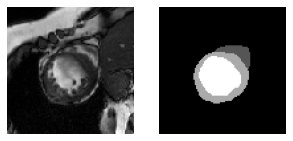

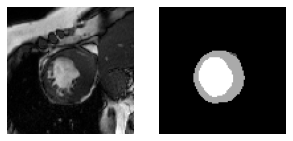

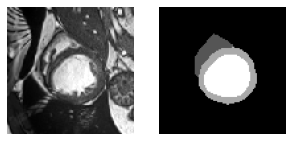

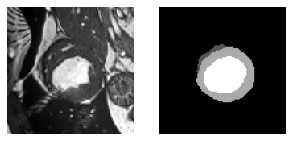

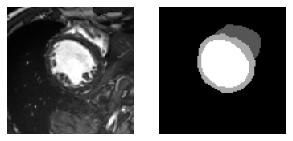

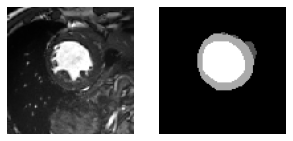

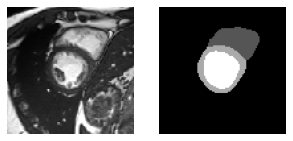

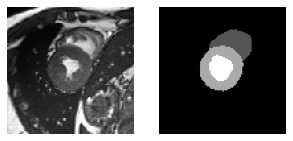

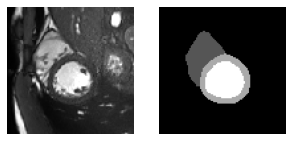

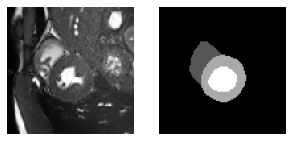

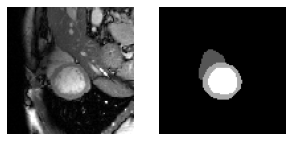

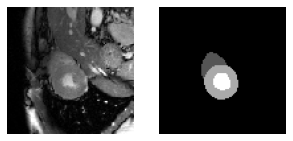

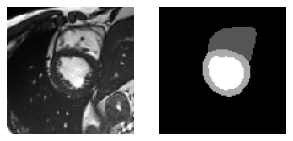

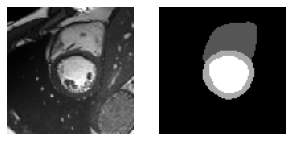

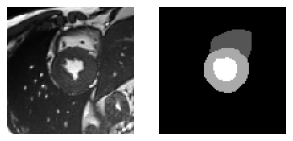

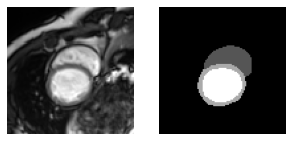

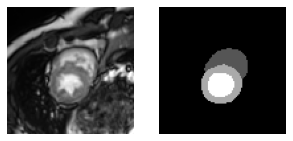

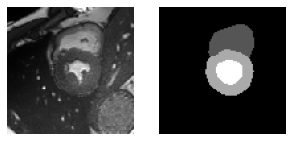

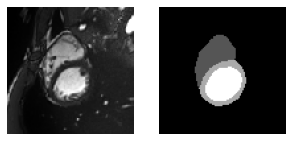

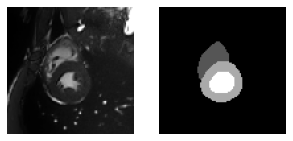

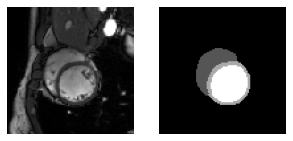

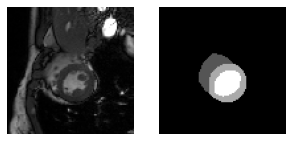

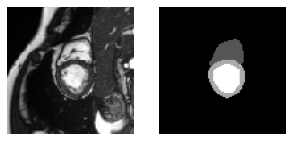

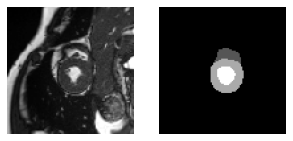

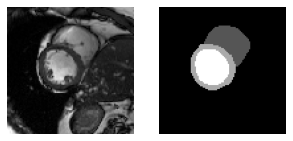

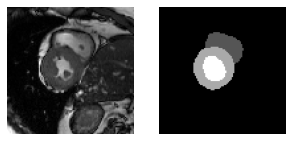

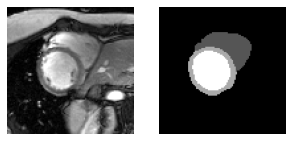

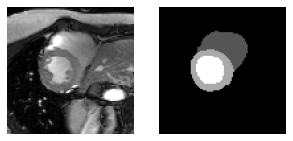

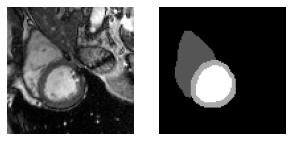

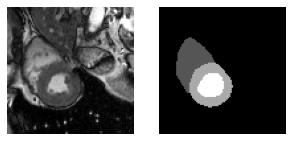

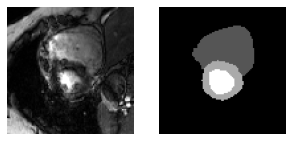

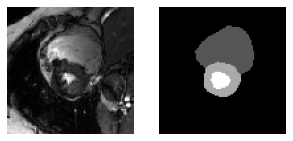

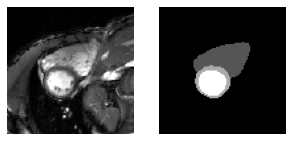

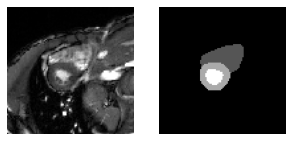

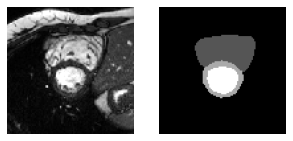

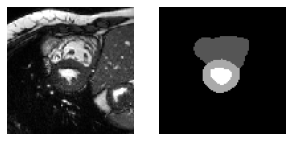

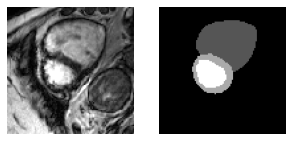

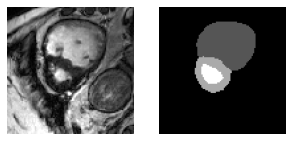

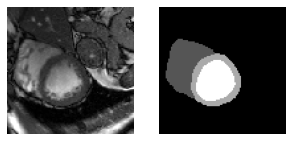

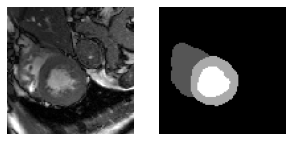

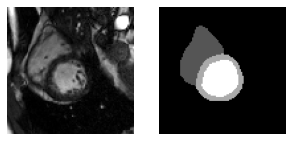

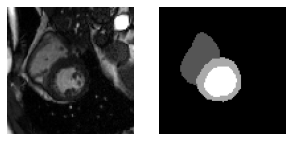

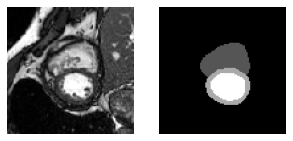

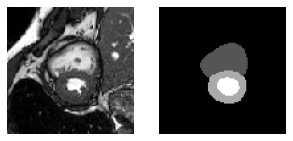

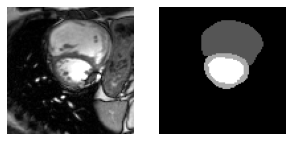

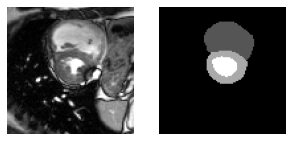

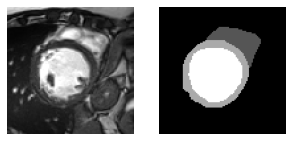

In [22]:
# Plot the predicted pictures from the training dataset 
test_data_path = './data/train'
test_set = TestDataset(test_data_path)
test_data_loader = DataLoader(dataset=test_set, num_workers=1, batch_size=4, shuffle=False)

# Load the model
model_UNet3plus.eval()
model_UNet.eval()

w = 0.74

for j, sample in enumerate(test_data_loader):
    imgList = sample
    for i in range(imgList.shape[0]):

        # Run the model
        img = imgList[i].to(device)
        output = model_UNet3plus(img.unsqueeze(0).unsqueeze(0))
        output2 = model_UNet(img.unsqueeze(0).unsqueeze(0))
        
        # Mix the model
        output = output*w + output2*(1-w)
        output = output.argmax(dim=1)

        # Plot the pictures
        plt.figure(figsize=(5,5))
        plt.subplot(1, 2, 1)
        plt.imshow(img.to('cpu'), cmap='gray')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(output.squeeze().to('cpu'), cmap='gray')
        plt.axis('off')
        
        pictureName = "cmr" + str(121+j*4+i) + "_mask.png"
        cv2.imwrite(os.path.join('./test/mask',pictureName), output.cpu().numpy().squeeze(0).astype('uint8'))
        plt.show()

In [18]:
# Define the function of confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[0.99 0.08 0.04 0.  ]
 [0.01 0.89 0.01 0.  ]
 [0.   0.03 0.92 0.05]
 [0.   0.   0.03 0.95]]


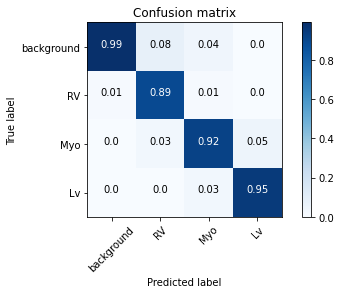

validation loss: 1.552116


In [19]:
# Initialization
y_mmpre = []
y_mmlabel = []

# Initialize the validting dataset
val_data_path = './data/val'
val_num_workers = 1
val_batch_size = 1
val_set = TrainDataset(val_data_path)
val_data_loader = DataLoader(dataset=val_set, num_workers=val_num_workers, batch_size=val_batch_size, shuffle=True)

# Initialize the Loss
val_total_loss = 0

# For-loop on the validating dataset
for iteration, sample in enumerate(val_data_loader):
    
    # Run the model
    img, mask = sample
    img = img.to(device)
    mask = mask.to(device)
    img = img.unsqueeze(1)
    with torch.no_grad():
        output = model_UNet3plus(img)
        output2 = model_UNet(img)
        # Mix the model
        output = output*w + output2*(1-w)
    output2 = output.argmax(dim = 1)

    # Convert the outputs and labels to a 1-dimensional vector
    for i in range(96):
        for j in range(96):
            y_mmpre.append(int(output2[0][i][j].item()))
            y_mmlabel.append(int(mask[0][i][j].item()))
    # Calculate loss
    loss = my_loss.forward2(output, mask.long(),mask,output)
    val_total_loss += loss

# Initialize confusion matrix
cm = np.zeros((4, 4))
cnt = [0, 0, 0, 0]
# Calculate the number of classes in labels and predictions
for i in range(len(y_mmlabel)):
    cnt[y_mmlabel[i]] = cnt[y_mmlabel[i]] + 1
for i in range(len(y_mmpre)):
    cm[y_mmpre[i]][y_mmlabel[i]] = cm[y_mmpre[i]][y_mmlabel[i]] + 1
for i in range(4):
    for j in range(4):
        cm[i][j] = cm[i][j] / cnt[j]
        cm[i][j] = round(cm[i][j], 2) # Take two decimal places
  
# Define Class name
class_names = ['background', 'RV', 'Myo', 'Lv'] 

# Plot the non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names, normalize=False,
                      title='Confusion matrix')
plt.savefig('Unet_3_3.jpg')
plt.show()

# Output the Loss
print("validation loss: %f" % (val_total_loss / 20))

ave val dice: 0.8860470358108581


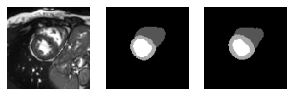

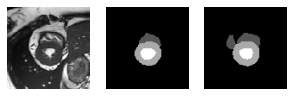

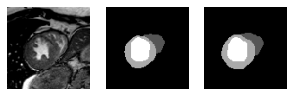

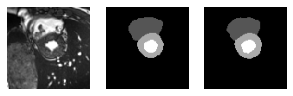

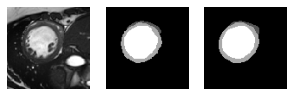

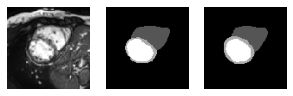

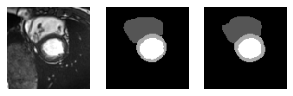

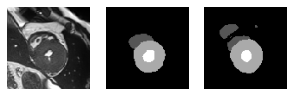

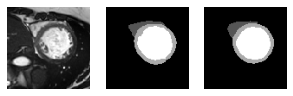

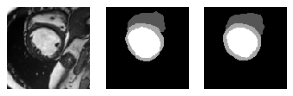

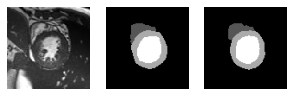

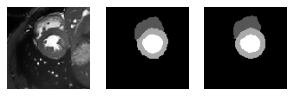

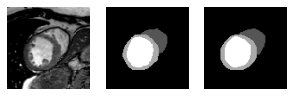

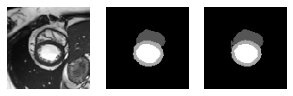

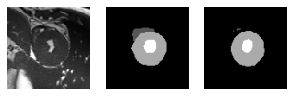

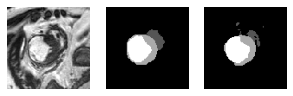

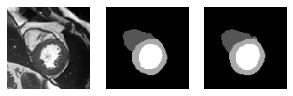

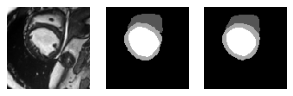

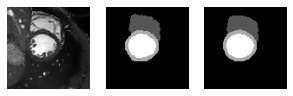

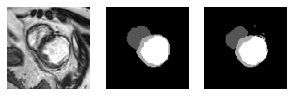

In [20]:
# Calculate the model dice score in validation 
dice = 0

for i, sample in enumerate(val_data_loader):
    imgList, maskList = sample
    for i in range(imgList.shape[0]):
        img = imgList[i].to(device)
        mask = maskList[i].to(device)
        # Run the model
        output = model_UNet3plus(img.unsqueeze(0).unsqueeze(0))
        output2 = model_UNet(img.unsqueeze(0).unsqueeze(0))
        
        # Mix the model
        output = output * w + output2 * (1 - w)
        output = output.argmax(dim=1)
        
        plt.figure(figsize=(5,5))
        plt.subplot(1, 3, 1)
        plt.imshow(img.to('cpu'), cmap='gray')
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(mask.to('cpu'), cmap='gray')
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.imshow(output.squeeze().to('cpu'), cmap='gray')
        plt.axis('off')
        
        #plt.show()
        mask.to('cpu')
        output.to('cpu')
        dice_score = categorical_dice(output.data.cpu().numpy(), mask.data.cpu().numpy(),1)
        dice_score += categorical_dice(output.data.cpu().numpy(), mask.data.cpu().numpy(),2)
        dice_score += categorical_dice(output.data.cpu().numpy(), mask.data.cpu().numpy(),3)
        dice_score /= 3
        dice += dice_score
dice/=20
print("ave val dice:",dice)

In [21]:
def rle_encoding(x):
    '''
    *** Credit to https://www.kaggle.com/rakhlin/fast-run-length-encoding-python ***
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def submission_converter(mask_directory, path_to_save):
    writer = open(os.path.join(path_to_save, "submission.csv"), 'w')
    writer.write('id,encoding\n')

    files = os.listdir(mask_directory)

    for file in files:
        name = file[:-4]
        mask = cv2.imread(os.path.join(mask_directory, file), cv2.IMREAD_UNCHANGED)

        mask1 = (mask == 1)
        mask2 = (mask == 2)
        mask3 = (mask == 3)

        encoded_mask1 = rle_encoding(mask1)
        encoded_mask1 = ' '.join(str(e) for e in encoded_mask1)
        encoded_mask2 = rle_encoding(mask2)
        encoded_mask2 = ' '.join(str(e) for e in encoded_mask2)
        encoded_mask3 = rle_encoding(mask3)
        encoded_mask3 = ' '.join(str(e) for e in encoded_mask3)

        writer.write(name + '1,' + encoded_mask1 + "\n")
        writer.write(name + '2,' + encoded_mask2 + "\n")
        writer.write(name + '3,' + encoded_mask3 + "\n")

    writer.close()

In [ ]:
mask_directory = './test/mask'
save = './data/test'
submission_converter(mask_directory,save)